It working with:
Keras==2.2.5
Tensorflow==1.15.0

It work slowly on CPU, better train on GPU.

In [1]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

Using TensorFlow backend.


In [2]:
# class that defines and loads the dataset
class MasksDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "without_mask")
        self.add_class("dataset", 2, "mask_weared_incorrect")
        self.add_class("dataset", 3, "with_mask")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        # find all images
        for i, filename in enumerate(listdir(images_dir)):
            # extract image id
            # we want first 170 images to put in test set and rest in training set
            if is_train and i < 170:
                continue
            elif not is_train and i >= 170:
                continue
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        names = list()
        for obj in root.findall('./object'):
            name = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            names.append(name)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, names, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, names, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(names[i]))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = MasksDataset()
train_set.load_dataset(r'../data', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = MasksDataset()
test_set.load_dataset(r'../data', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 683
Test: 170


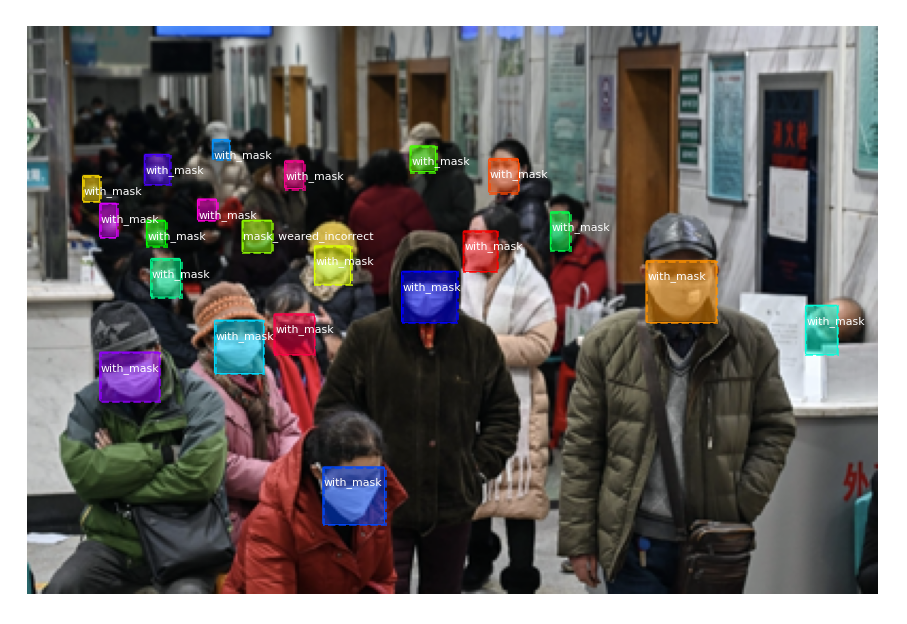

In [4]:
image_id = 177
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [5]:
# define a configuration for the model
class MasksConfig(Config):
    # Give the configuration a recognizable name
    NAME = "masks_cfg"
    # Number of classes (background + masks classes)
    NUM_CLASSES = 1 + 3
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 683

In [6]:
# prepare config
config = MasksConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:

# load weights (mscoco) and exclude the output layers
model.load_weights(r'../mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


In [8]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers = "heads")


Starting at epoch 0. LR=0.001

Checkpoint Path: .\mask_rcnn_masks_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_

C:\Users\spawe\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\spawe\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\spawe\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/10


C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/683 [..............................] - ETA: 5:44:17 - loss: 5.3617 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.2333 - mrcnn_class_loss: 1.6065 - mrcnn_bbox_loss: 1.3015 - mrcnn_mask_loss: 1.1913

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/683 [..............................] - ETA: 5:23:29 - loss: 7.0259 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 3.1098 - mrcnn_class_loss: 1.2393 - mrcnn_bbox_loss: 1.6109 - mrcnn_mask_loss: 0.9123

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/683 [..............................] - ETA: 5:19:07 - loss: 6.1586 - rpn_class_loss: 0.3761 - rpn_bbox_loss: 2.3187 - mrcnn_class_loss: 1.0618 - mrcnn_bbox_loss: 1.6269 - mrcnn_mask_loss: 0.7751

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/683 [..............................] - ETA: 5:14:41 - loss: 5.5654 - rpn_class_loss: 0.2916 - rpn_bbox_loss: 2.0447 - mrcnn_class_loss: 0.8644 - mrcnn_bbox_loss: 1.6315 - mrcnn_mask_loss: 0.7331

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/683 [..............................] - ETA: 5:11:09 - loss: 5.2130 - rpn_class_loss: 0.2552 - rpn_bbox_loss: 2.0093 - mrcnn_class_loss: 0.7098 - mrcnn_bbox_loss: 1.5230 - mrcnn_mask_loss: 0.7158

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/683 [..............................] - ETA: 5:10:26 - loss: 4.9137 - rpn_class_loss: 0.2155 - rpn_bbox_loss: 1.9097 - mrcnn_class_loss: 0.6159 - mrcnn_bbox_loss: 1.4438 - mrcnn_mask_loss: 0.7287

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/683 [..............................] - ETA: 5:08:56 - loss: 4.5733 - rpn_class_loss: 0.2139 - rpn_bbox_loss: 1.7432 - mrcnn_class_loss: 0.5528 - mrcnn_bbox_loss: 1.3443 - mrcnn_mask_loss: 0.7191

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/683 [..............................] - ETA: 5:07:52 - loss: 4.3164 - rpn_class_loss: 0.2008 - rpn_bbox_loss: 1.6135 - mrcnn_class_loss: 0.5389 - mrcnn_bbox_loss: 1.2682 - mrcnn_mask_loss: 0.6951

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/683 [..............................] - ETA: 5:06:13 - loss: 4.1193 - rpn_class_loss: 0.1878 - rpn_bbox_loss: 1.5101 - mrcnn_class_loss: 0.5262 - mrcnn_bbox_loss: 1.2314 - mrcnn_mask_loss: 0.6638

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/683 [..............................] - ETA: 5:05:04 - loss: 4.0405 - rpn_class_loss: 0.1753 - rpn_bbox_loss: 1.5017 - mrcnn_class_loss: 0.4937 - mrcnn_bbox_loss: 1.1961 - mrcnn_mask_loss: 0.6737

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/683 [..............................] - ETA: 5:04:14 - loss: 3.9106 - rpn_class_loss: 0.1596 - rpn_bbox_loss: 1.4240 - mrcnn_class_loss: 0.4609 - mrcnn_bbox_loss: 1.1786 - mrcnn_mask_loss: 0.6875

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/683 [..............................] - ETA: 5:03:47 - loss: 3.8686 - rpn_class_loss: 0.1841 - rpn_bbox_loss: 1.3801 - mrcnn_class_loss: 0.4813 - mrcnn_bbox_loss: 1.1503 - mrcnn_mask_loss: 0.6729

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/683 [..............................] - ETA: 5:03:15 - loss: 3.7924 - rpn_class_loss: 0.1808 - rpn_bbox_loss: 1.3361 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 1.1422 - mrcnn_mask_loss: 0.6614

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/683 [..............................] - ETA: 5:02:56 - loss: 3.7209 - rpn_class_loss: 0.1682 - rpn_bbox_loss: 1.3223 - mrcnn_class_loss: 0.4499 - mrcnn_bbox_loss: 1.1262 - mrcnn_mask_loss: 0.6544

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/683 [..............................] - ETA: 5:01:59 - loss: 3.6238 - rpn_class_loss: 0.1591 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 1.1267 - mrcnn_mask_loss: 0.6389

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/683 [..............................] - ETA: 5:01:36 - loss: 3.5399 - rpn_class_loss: 0.1589 - rpn_bbox_loss: 1.2274 - mrcnn_class_loss: 0.4389 - mrcnn_bbox_loss: 1.0914 - mrcnn_mask_loss: 0.6232

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/683 [..............................] - ETA: 5:01:03 - loss: 3.5032 - rpn_class_loss: 0.1585 - rpn_bbox_loss: 1.2293 - mrcnn_class_loss: 0.4372 - mrcnn_bbox_loss: 1.0654 - mrcnn_mask_loss: 0.6128

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/683 [..............................] - ETA: 5:00:33 - loss: 3.4761 - rpn_class_loss: 0.1579 - rpn_bbox_loss: 1.2362 - mrcnn_class_loss: 0.4289 - mrcnn_bbox_loss: 1.0468 - mrcnn_mask_loss: 0.6063

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/683 [..............................] - ETA: 5:00:11 - loss: 3.3828 - rpn_class_loss: 0.1515 - rpn_bbox_loss: 1.1886 - mrcnn_class_loss: 0.4209 - mrcnn_bbox_loss: 1.0234 - mrcnn_mask_loss: 0.5984

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/683 [..............................] - ETA: 4:59:23 - loss: 3.3278 - rpn_class_loss: 0.1480 - rpn_bbox_loss: 1.1602 - mrcnn_class_loss: 0.4044 - mrcnn_bbox_loss: 1.0132 - mrcnn_mask_loss: 0.6020

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/683 [..............................] - ETA: 4:58:52 - loss: 3.2681 - rpn_class_loss: 0.1411 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.3900 - mrcnn_bbox_loss: 0.9979 - mrcnn_mask_loss: 0.6086

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/683 [..............................] - ETA: 4:58:20 - loss: 3.2280 - rpn_class_loss: 0.1398 - rpn_bbox_loss: 1.1069 - mrcnn_class_loss: 0.3874 - mrcnn_bbox_loss: 0.9880 - mrcnn_mask_loss: 0.6060

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/683 [>.............................] - ETA: 4:57:40 - loss: 3.1809 - rpn_class_loss: 0.1386 - rpn_bbox_loss: 1.0782 - mrcnn_class_loss: 0.3926 - mrcnn_bbox_loss: 0.9719 - mrcnn_mask_loss: 0.5996

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/683 [>.............................] - ETA: 4:57:29 - loss: 3.1294 - rpn_class_loss: 0.1360 - rpn_bbox_loss: 1.0500 - mrcnn_class_loss: 0.3913 - mrcnn_bbox_loss: 0.9581 - mrcnn_mask_loss: 0.5939

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/683 [>.............................] - ETA: 4:57:12 - loss: 3.1082 - rpn_class_loss: 0.1324 - rpn_bbox_loss: 1.0460 - mrcnn_class_loss: 0.3954 - mrcnn_bbox_loss: 0.9462 - mrcnn_mask_loss: 0.5882

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/683 [>.............................] - ETA: 4:56:38 - loss: 3.0505 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 1.0228 - mrcnn_class_loss: 0.3886 - mrcnn_bbox_loss: 0.9288 - mrcnn_mask_loss: 0.5814

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/683 [>.............................] - ETA: 4:56:18 - loss: 3.0023 - rpn_class_loss: 0.1266 - rpn_bbox_loss: 1.0018 - mrcnn_class_loss: 0.3852 - mrcnn_bbox_loss: 0.9131 - mrcnn_mask_loss: 0.5757

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/683 [>.............................] - ETA: 4:55:49 - loss: 2.9507 - rpn_class_loss: 0.1232 - rpn_bbox_loss: 0.9885 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.8943 - mrcnn_mask_loss: 0.5687

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/683 [>.............................] - ETA: 4:55:14 - loss: 2.8926 - rpn_class_loss: 0.1201 - rpn_bbox_loss: 0.9617 - mrcnn_class_loss: 0.3670 - mrcnn_bbox_loss: 0.8786 - mrcnn_mask_loss: 0.5652

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/683 [>.............................] - ETA: 4:54:39 - loss: 2.8392 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.9457 - mrcnn_class_loss: 0.3558 - mrcnn_bbox_loss: 0.8616 - mrcnn_mask_loss: 0.5595

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/683 [>.............................] - ETA: 4:54:18 - loss: 2.7997 - rpn_class_loss: 0.1162 - rpn_bbox_loss: 0.9232 - mrcnn_class_loss: 0.3538 - mrcnn_bbox_loss: 0.8509 - mrcnn_mask_loss: 0.5555

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/683 [>.............................] - ETA: 4:53:47 - loss: 2.7575 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 0.9049 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.8423 - mrcnn_mask_loss: 0.5489

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/683 [>.............................] - ETA: 4:53:11 - loss: 2.7151 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.8865 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.8318 - mrcnn_mask_loss: 0.5445

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/683 [>.............................] - ETA: 4:52:44 - loss: 2.6697 - rpn_class_loss: 0.1087 - rpn_bbox_loss: 0.8700 - mrcnn_class_loss: 0.3340 - mrcnn_bbox_loss: 0.8186 - mrcnn_mask_loss: 0.5384

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/683 [>.............................] - ETA: 4:52:17 - loss: 2.6417 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.8548 - mrcnn_class_loss: 0.3355 - mrcnn_bbox_loss: 0.8075 - mrcnn_mask_loss: 0.5338

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/683 [>.............................] - ETA: 4:51:36 - loss: 2.6105 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.8466 - mrcnn_class_loss: 0.3266 - mrcnn_bbox_loss: 0.7986 - mrcnn_mask_loss: 0.5292

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/683 [>.............................] - ETA: 4:51:06 - loss: 2.6037 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.8388 - mrcnn_class_loss: 0.3285 - mrcnn_bbox_loss: 0.7956 - mrcnn_mask_loss: 0.5317

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/683 [>.............................] - ETA: 4:50:32 - loss: 2.5781 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 0.8251 - mrcnn_class_loss: 0.3269 - mrcnn_bbox_loss: 0.7891 - mrcnn_mask_loss: 0.5305

C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\spawe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


KeyboardInterrupt: 